## Extracting data from Table Image, detected using YoLo model

### 1. Loading necessary libraries

In [1]:
import pandas as pd
import numpy as np
import cv2 as cv
import torch
import re
import pytesseract
from pytesseract import Output
from tqdm import tqdm
from matplotlib import pyplot as plt

#### 1.1 Loading Tesseract engine

In [2]:
pytesseract.pytesseract.tesseract_cmd = "Tesseract_OCR/tesseract.exe"

#### 1.2 Loading Trained YoLo model

In [3]:
model_name = 'yolo_model/best.pt'
model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_name, force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to C:\Users\sarath.LOTUSWIRELESS/.cache\torch\hub\master.zip
YOLOv5  2022-6-27 Python-3.9.2 torch-1.10.2+cpu CPU

Fusing layers... 
Model summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


### 2. Detecting Table with YoLo model

#### 1. Loading an Image to test

* I have blurred the image, as this is an invoice of my current company, may be I shouldn't share it.
* I found this image realistic, so I have used it instead of online downloaded images.
* I have passed a non-blurred image to my model in the below cells.

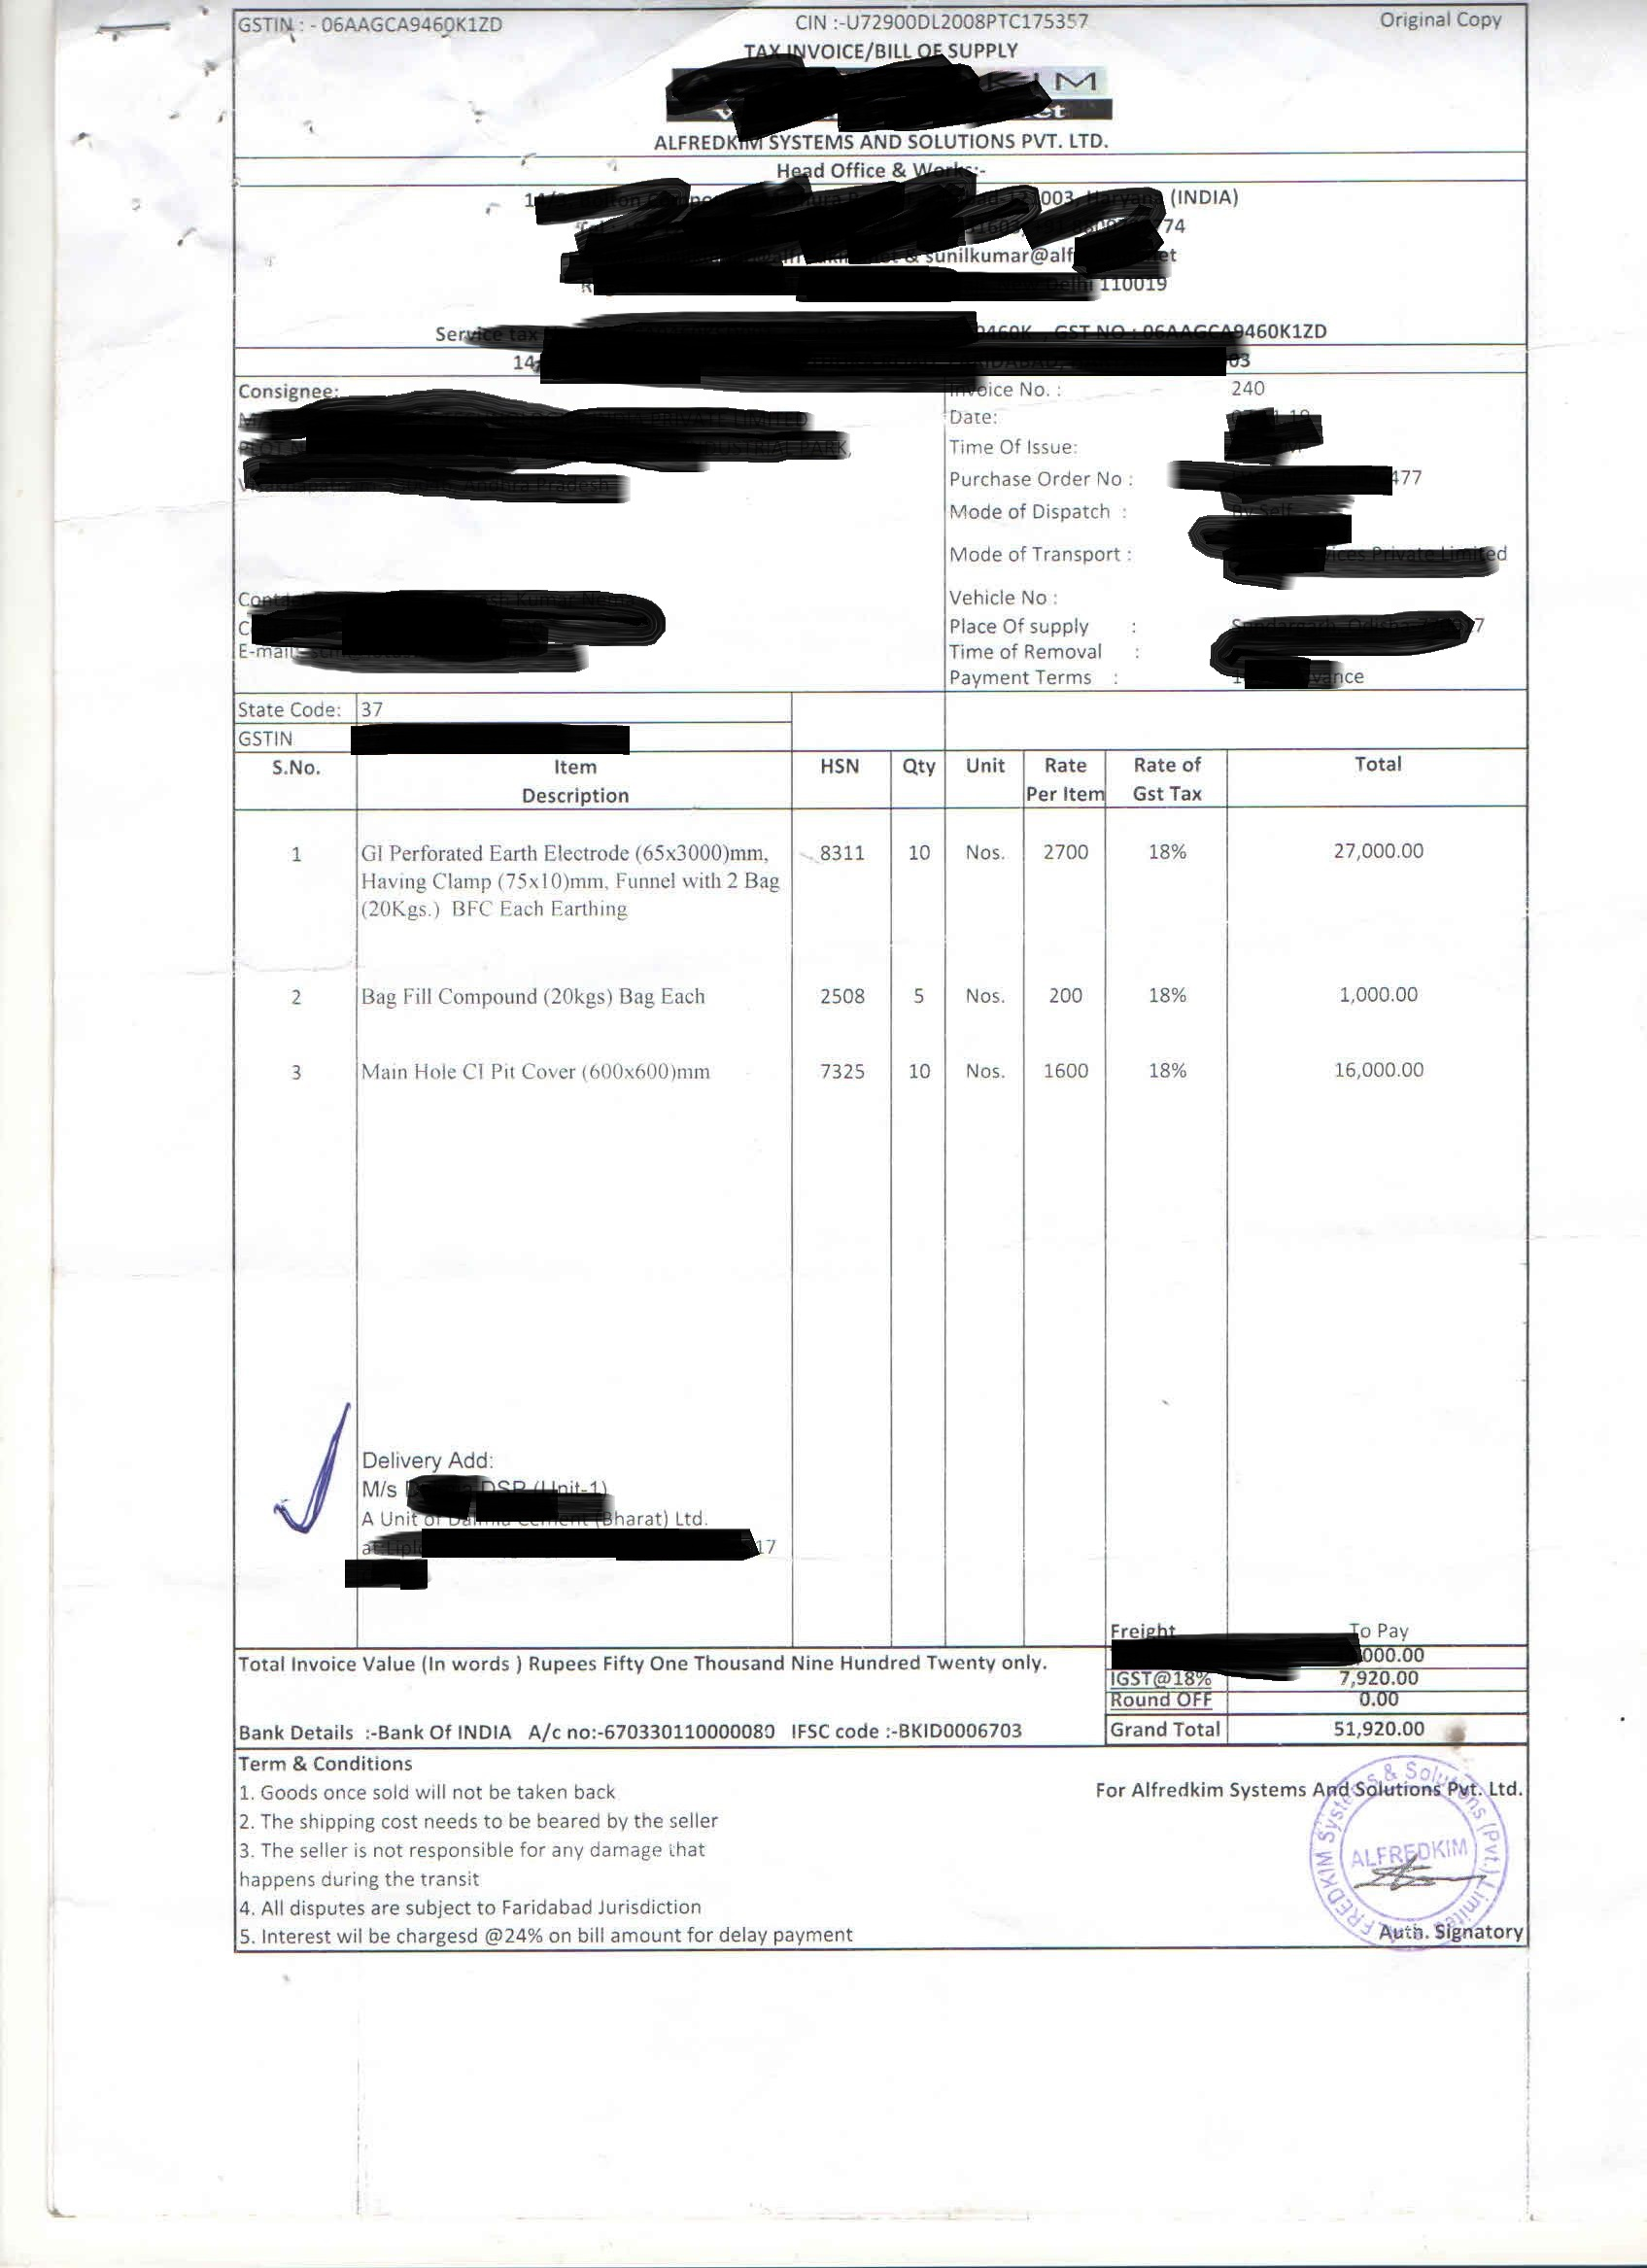

#### 2.2 Image pre-processing

In [4]:
file_name = 'invo_12.jpg' #'test_image.png'

img = cv.imread(file_name)
original_img = img.copy()

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
ret, img_thresh = cv.threshold(gray, 150, 255, cv.THRESH_BINARY)

# blur = cv.GaussianBlur(gray,(5,5),0)
# ret, frame = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

h, w = img_thresh.shape
print(h, w, ' : ', img_thresh.shape)

2334 1695  :  (2334, 1695)


#### 2.3 Detecting Table image & crop the image to the predicted bounding coordinates.

* currently I extracting data from single table only, if multiple tables are detected, the data is extracted from the table that has maximum area.

In [5]:
device = 'cpu'
model.to(device)
frame = [img_thresh]
results = model(img_thresh)
labels, cord = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]

arr = []

# storing bouding-box coordinates of each table in a list.
for i in range(len(labels)):
    if labels[i] == 1:
        row = cord[i]
        x1, y1, x2, y2 = int(row[0]*w), int(row[1]*h), int(row[2]*w), int(row[3]*h)
        arr.append([y1, y2, x1, x2])

print('no of tables detected : ', len(arr))

# choosing the table that has maximum area
areas = []
for i in arr:
    h = i[1]-i[0]
    w = i[3]-i[2]
    ar = h*w
    areas.append(ar)
max_area_index = np.argmax(areas)
tbl = arr[max_area_index]

# crop the table_region of large table..
tbl_roi = frame[0][tbl[0] : tbl[1], tbl[2] : tbl[3]]
original_tbl_roi = original_img[tbl[0] : tbl[1], tbl[2] : tbl[3]]

cv.imwrite('results/tbl_roi.jpg', tbl_roi)

print('Frame shape after model prediction : ', tbl_roi.shape)

no of tables detected :  1
Frame shape after model prediction :  (962, 1279)


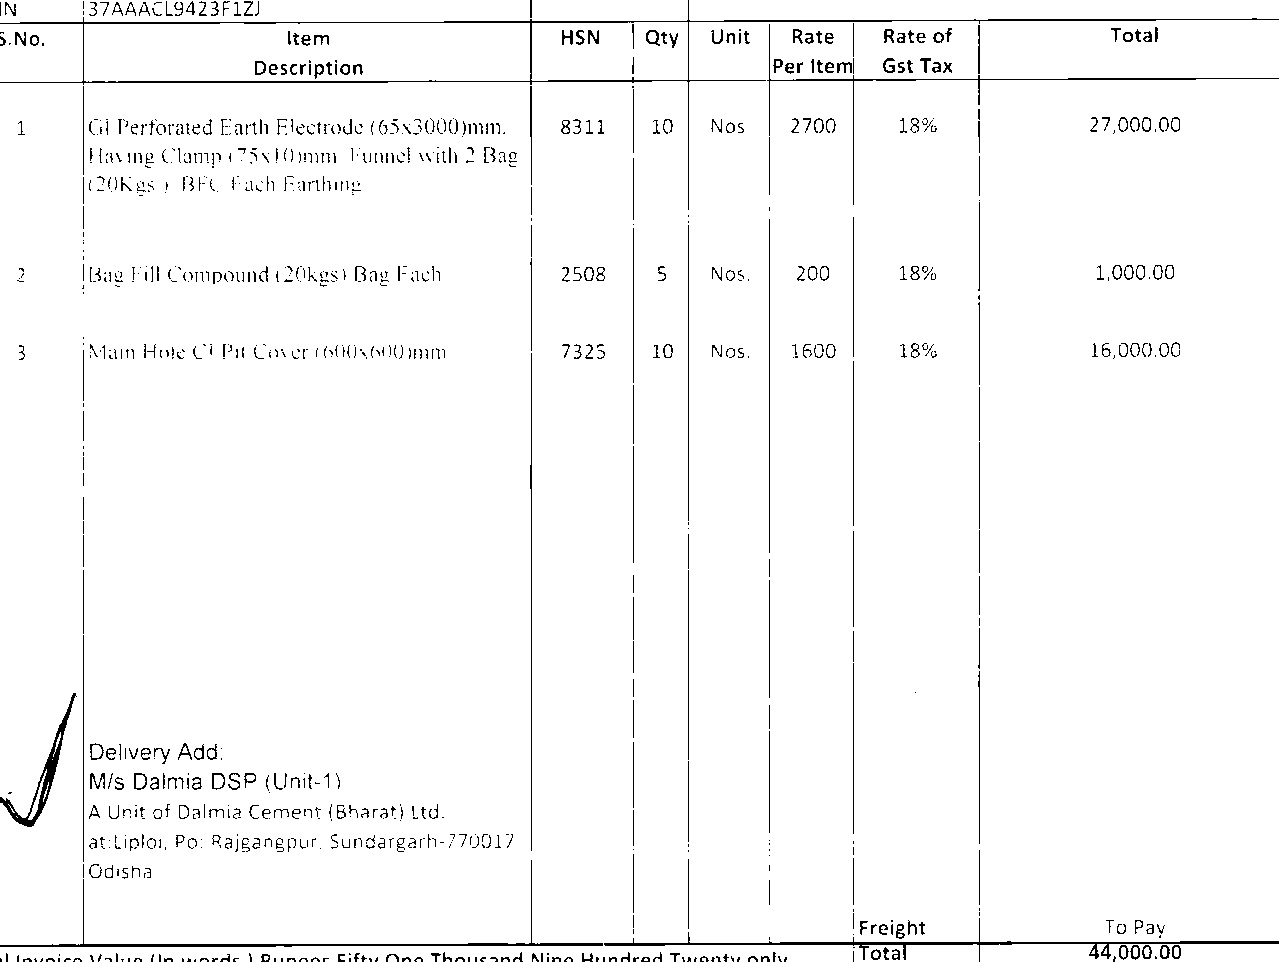

### 3. Using Tesseract OCR to extract text from Image :

#### 3.1 Image to data

* using image_to_data(tbl_roi) function to get the tesseract ocr data in the form of list of lists, It contains coordinates and confidence values of each word of the text.

In [6]:
tbl_h, roi_w = tbl_roi.shape

results = pytesseract.image_to_data(tbl_roi)

data = list(map(lambda x: x.split('\t'), results.split('\n')))
df = pd.DataFrame(data[1:], columns=data[0])
df[30:35].head()

,level,page_num,block_num,par_num,line_num,...,top,width,height,conf,text
30,5,1,7,1,1,...,0,30,25,39.439255,12)
31,4,1,7,1,2,...,27,1158,21,-1,
32,5,1,7,1,2,...,32,44,14,40.052986,>No.
33,5,1,7,1,2,...,31,41,15,52.238670,Item
34,5,1,7,1,2,...,30,37,15,96.367493,HSN


#### 3.2 Cleaning the OCR data

In [7]:
df.dropna(inplace=True) # drop the missing in rows

df['conf'] = [int(float(i)) for i in df['conf'].values] # convert confidence values to float

# convert all other columns to int datatype.
col_int = ['level','page_num','block_num','par_num','line_num','word_num','left','top','width','height','conf']
df[col_int] = df[col_int].astype(int)

In [8]:
word_data = []

for i in range(len(df)):
    temp = {}
    txt = df["text"][i]
    # excluding empty text..
    if txt != '' and txt != ' ' and txt != '\n':
        temp['word_no'] = i
        temp['level'] = df["level"][i]
        temp['left'] = df["left"][i]
        temp['top'] = df["top"][i]
        temp['top_left'] = (df["top"][i] + df["left"][i])
        temp['width'] = df["width"][i]
        temp['height'] = df["height"][i]
        temp['right'] = (df["left"][i] + df["width"][i])
        temp['bottom'] = (df["top"][i] + df["height"][i])
        temp['conf'] = round(float(df["conf"][i]), 2)
        temp['text'] = txt
        word_data.append(temp)
word_data_df = pd.DataFrame(word_data)
word_data_df.head(5)

,word_no,level,left,top,top_left,...,height,right,bottom,conf,text
0,28,5,0,0,0,...,25,19,25,27.0,NE
1,29,5,83,1,84,...,15,259,16,0.0,(S7AAACLE42Z3F
2,30,5,233,0,233,...,25,263,25,39.0,12)
3,32,5,0,32,32,...,14,44,46,40.0,>No.
4,33,5,288,31,319,...,15,329,46,52.0,Item


In [9]:
# sorting the word data, list of dicts, based on top_coordinate. So, words will be in ascending order of their y-coordinate.

word_data = sorted(word_data, key = lambda i: i['top'])

### 4. Identifying Rows and columns

#### 4.1 Identifying Rows

* with the help of tesseract-ocr bounding-box coordinates of all words, I am finding the words that lie on the same horizontal line(*can be approximately straight), all those words are treated as same row, and added to a table_list as  first row of the table.
* The advantage here is, whether a table has borders or not, this method will work. And I decided to pass the whole table_image to tesseract-ocr instead of passing each cell image to tesseract. 
* One problem is, it will treat each new line as a row, we will solve this issue in the columns part.

In [10]:
def words_on_same_line(d1, d2):
    d1_y_mid = (d1['top']+d1['bottom'])/2
    d2_y_mid = (d2['top']+d2['bottom'])/2
    if d1['top'] <= d2_y_mid <= d1['bottom']:
        return True
    elif d2['top'] <= d1_y_mid <= d2['bottom']:
        return True
    else:
        return False

new_data = []
temp = []
all_words = []
curr_word = ''

for i in range(len(word_data)):
    if i+1 < len(word_data)-1:
        temp.append(word_data[i])
        curr_word += (' '+word_data[i]['text'])
        if words_on_same_line(word_data[i], word_data[i+1]):
            pass
        else:
            new_data.append(temp)
            temp = []
            all_words.append(curr_word)
            curr_word = ''
print('>> Lines in the table image : ')
all_words

>> Lines in the table image : 


[' NE 12) (S7AAACLE42Z3F',
 ' | Total of Unit Rate Rate HSN Qty Item >No.',
 ' Description item| Gst Tax Per',
 ' | 27,000.00 (65x3000)mn. 2700 18% Ci Perforated Earth Electrode 8311 10 Nos 1',
 ' Vunnel with 2 Bag Having Clamp 75s 01mm',
 ' (2OKas Fach Farthing BRO +',
 ' 1,000.00 Fill Compound (20kgs) Bag Fach 5 200 18% Bag 2508 Nos 2',
 ' 16,000.00 18% Main Hote Cl Pit Cover 7325 10 1600 3 fof. odonam Nos',
 ' I',
 ' |',
 ' Delivery Add',
 ' M/s Dalmia DSP (Unit-1)',
 ' af Dalmia (Bharat) Ltd A Unit Cement',
 ' at:Liplo1, Suncargarh-770017 Po: Rajgangpur,',
 " |Odisna '",
 ' lEreight']

In [11]:
# maintaining the order based on left coordinates of the word in a row.

sorted_new_data = []
sorted_line_lists = []

for lst in new_data:
    new_lst = sorted(lst, key = lambda i: i['left'])
    for i in new_lst:
        sorted_new_data.append(i)
    sorted_line_lists.append(new_lst)

##### 4.1.1  Drawing horizontal line after each row

In [14]:
tbl_h, tbl_w = tbl_roi.shape

hori_lines = []

tbl_rows = original_tbl_roi.copy()

c = 0
for lst in sorted_line_lists:
    y1 = lst[0]['top']
    if c == 0:
        hori_lines.append([(0, y1), (tbl_w, y1)])
        cv.line(tbl_rows, (0, y1), (tbl_w, y1), (0, 0, 255), 2)
    elif (y1 - y2) > tbl_w//8:
        hori_lines.append([(0, y2), (tbl_w, y2)])
        cv.line(tbl_rows, (0, y2), (tbl_w, y2), (0, 0, 255), 2)
        cv.line(tbl_rows, (0, y1), (tbl_w, y1), (0, 0, 255), 2)
    else:
        mid_y = (y2+y1)//2
        hori_lines.append([(0, mid_y), (tbl_w, mid_y)])
        cv.line(tbl_rows, (0, mid_y), (tbl_w, mid_y), (0, 0, 255), 2)
    y2 = lst[-1]['bottom']
    if c == len(sorted_line_lists)-1:
        hori_lines.append([(0, y2), (tbl_w, y2)])
        cv.line(tbl_rows, (0, y2), (tbl_w, y2), (0, 0, 255), 2)
    c += 1
cv.imwrite('results/final_tbl_rows.jpg', tbl_rows)

True

##### all the rows of the table.

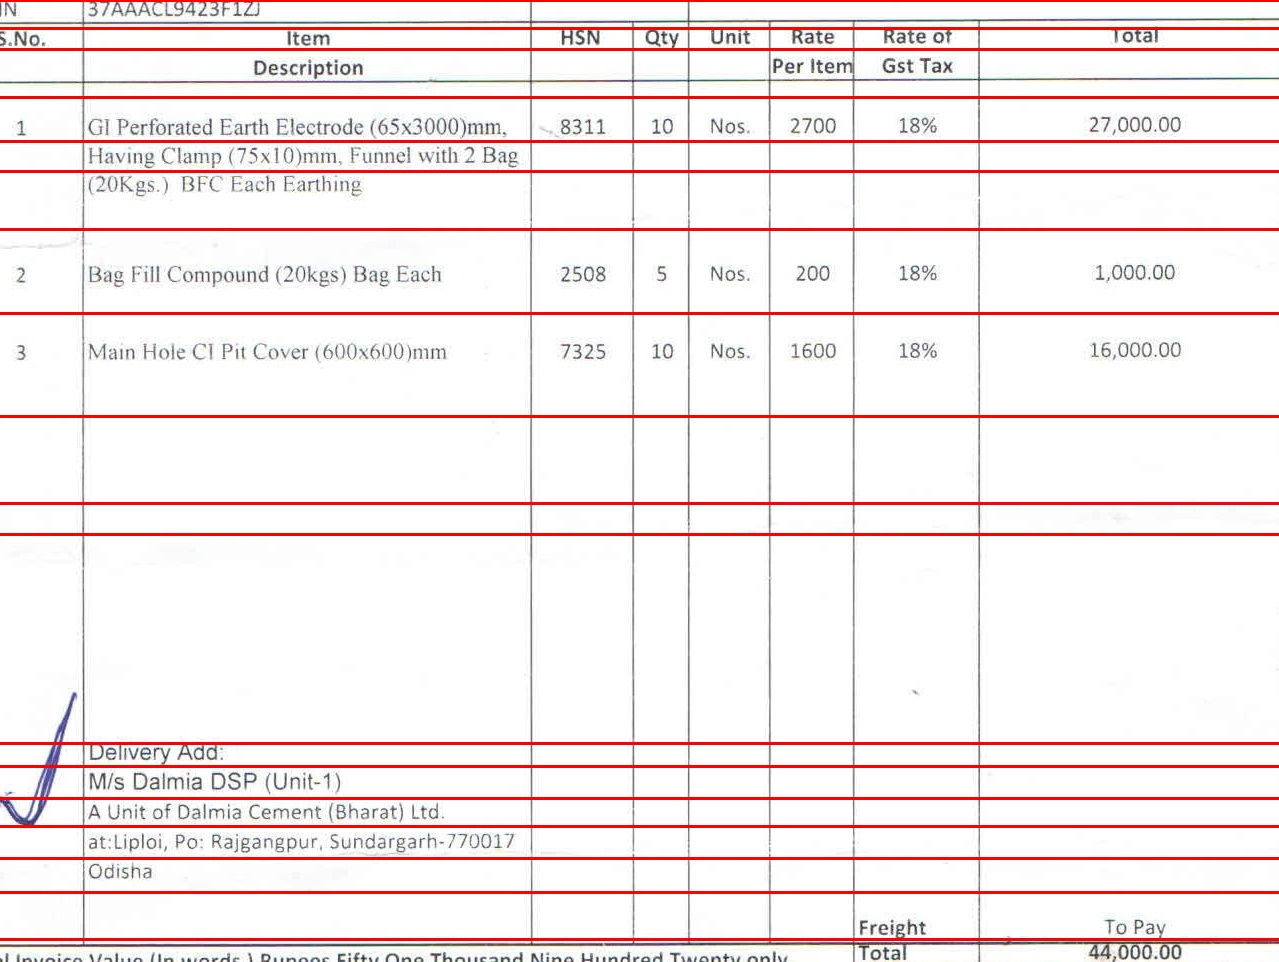

#### 4.2 Identifying Columns

* My approach to identify the columns is to identify the vertical gaps(possible lines) between the text.
* I will try to identify the long gaps between the text, and I draw a line at the mid point.
* choosing the right threshold to define a gap is important.

In [15]:
gray = cv.cvtColor(original_tbl_roi, cv.COLOR_BGR2GRAY)

# Apply adaptiveThreshold at the bitwise_not of gray, notice the ~ symbol
gray = cv.bitwise_not(gray)
bw = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 15, -2)

ah, aw = bw.shape
h, w = bw.shape

vertical = np.copy(bw)

# Specify size on vertical axis
rows = vertical.shape[0]
verticalsize = rows // 30
# Create structure element for extracting vertical lines through morphology operations
verticalStructure = cv.getStructuringElement(cv.MORPH_RECT, (1, verticalsize))
# Apply morphology operations
vertical = cv.erode(vertical, verticalStructure)
vertical = cv.dilate(vertical, verticalStructure)

* we will first find the long vertical white spaces, and we keep the image y-indecies in a array, and then we cluster the array with some threshold.
* two different numbers will be added to 2 different lists only if the difference between them is larger than the threshold(or max-gap)

In [16]:
def cluster(data, maxgap):
    data.sort()
    groups = [[data[0]]]
    for x in data[1:]:
        if abs(x - groups[-1][-1]) <= maxgap:
            groups[-1].append(x)
        else:
            groups.append([x])
    return groups
# cluster(col_list, 5)

existed_vert_lines = []

vert_lines = [0]
vert_lines += list(np.where(np.count_nonzero(vertical, axis=0) > h/4)[0]) # == 0
if len(vert_lines) > 3:
    if len(cluster(vert_lines, 5)) > 2:
        existed_vert_lines = cluster(vert_lines, 5)
len(existed_vert_lines), existed_vert_lines

(8,
 [[0],
  [82, 83, 84],
  [530, 531, 532],
  [632, 633],
  [688, 689],
  [768, 769, 770],
  [852, 853, 854],
  [978, 979]])

##### 4.2.1  final vertical line indexes after clustering

* Used to draw lines and seperate the words in the sorted word data based of x_coordinate values

In [17]:
final_vert_lines = []

if len(existed_vert_lines) == 0:
    # optimize..
    print('no_lines')
    blank_vert_lines = [0]
    blank_vert_lines += list(np.where(np.count_nonzero(bw, axis=1) < (w*5/100))[0]) # == 0
    clstr_vert = cluster(blank_vert_lines, 50)
    for i in clstr_vert:
        print(len(i), ' : ', i[0])
        line_num = i[0]
        final_vert_lines.append(line_num)
        cv.rectangle(original_tbl_roi, (i[0], 0), (i[0], h), (0, 0, 255), 2)
    # ----- use tess words sep as cols cols ---
else:
    for i in existed_vert_lines:
        print(len(i), ' : ', i[0])
        line_num = round(np.median(i)) # i[0]
        final_vert_lines.append(line_num)
        cv.rectangle(original_tbl_roi, (i[0], 0), (i[0], h), (0, 0, 255), 2)
final_vert_lines.append(w-1)

1  :  0
3  :  82
3  :  530
2  :  632
2  :  688
3  :  768
3  :  852
2  :  978


* the tesseract x-right coordinate is compared with vertical line index to add it in its respective column.

In [18]:
rows = []

for i in range(len(final_vert_lines)-1):
    if i == 0:
        st = 0
    else:
        st = final_vert_lines[i]
    cols = []
    for lst in sorted_line_lists:
        #print(len(lst))
        #val_flag = 0
        txt = ''
        for val in lst:
            if st <= val['right'] <= final_vert_lines[i+1]:
                #val_flag += 1
                txt += ' '+val['text']
        #if val_flag:
        cols.append(txt)
    rows.append(cols)
rows

[[' NE',
  ' >No.',
  '',
  ' 1',
  '',
  '',
  ' 2',
  ' 3',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  ''],
 [' (S7AAACLE42Z3F 12)',
  ' Item',
  ' Description',
  ' Ci Perforated Earth Electrode (65x3000)mn.',
  ' Having Clamp 75s 01mm Vunnel with 2 Bag',
  ' (2OKas + BRO Fach Farthing',
  ' Bag Fill Compound (20kgs) Bag Fach',
  ' Main Hote Cl Pit Cover fof. odonam',
  ' I',
  ' |',
  ' Delivery Add',
  ' M/s Dalmia DSP (Unit-1)',
  ' A Unit af Dalmia Cement (Bharat) Ltd',
  ' at:Liplo1, Po: Rajgangpur, Suncargarh-770017',
  ' |Odisna',
  ''],
 ['',
  ' HSN',
  '',
  ' 8311',
  '',
  '',
  ' 2508',
  ' 7325',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  ''],
 ['', ' Qty', '', ' 10', '', '', ' 5', ' 10', '', '', '', '', '', '', '', ''],
 ['',
  ' | Unit',
  '',
  ' | Nos',
  '',
  '',
  ' Nos',
  ' Nos',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  ''],
 ['',
  ' Rate',
  ' Per',
  ' 2700',
  '',
  '',
  ' 200',
  ' 1600',
  '',
  '',
  '',
  '',
  '',
  '',
  " '",
  ''],
 ['',
  ' 

##### 4.2.2  Mergin the sub-rows to main rows.

* * Inside the rows list the columns are in vertical form, we need that in horizontal way for merging the rows.
* As we have seen above while forming the rows, we treat each line a row. Now, we are merging the sub-rows to main rows based on some rules.
* If any row has very few non-null words compared to total column length, then that is merged with previous row(above row).
* we are limiting the horizontal lines, we only keep the main rows.

In [19]:
new_rows = np.array(rows).transpose()
new_rows

array([[' NE', ' (S7AAACLE42Z3F 12)', '', '', '', '', '', ''],
       [' >No.', ' Item', ' HSN', ' Qty', ' | Unit', ' Rate', ' Rate of', ' Total'],
       ['', ' Description', '', '', '', ' Per', ' item| Gst Tax', ''],
       [' 1', ' Ci Perforated Earth Electrode (65x3000)mn.', ' 8311', ' 10', ' | Nos', ' 2700', ' 18%', ' 27,000.00'],
       ['', ' Having Clamp 75s 01mm Vunnel with 2 Bag', '', '', '', '', '', ''],
       ['', ' (2OKas + BRO Fach Farthing', '', '', '', '', '', ''],
       [' 2', ' Bag Fill Compound (20kgs) Bag Fach', ' 2508', ' 5', ' Nos', ' 200', ' 18%', ' 1,000.00'],
       [' 3', ' Main Hote Cl Pit Cover fof. odonam', ' 7325', ' 10', ' Nos', ' 1600', ' 18%', ' 16,000.00'],
       ['', ' I', '', '', '', '', '', ''],
       ['', ' |', '', '', '', '', '', ''],
       ['', ' Delivery Add', '', '', '', '', '', ''],
       ['', ' M/s Dalmia DSP (Unit-1)', '', '', '', '', '', ''],
       ['', ' A Unit af Dalmia Cement (Bharat) Ltd', '', '', '', '', '', ''],
       ['', ' a

In [20]:
def merge_lists(l1, l2):
    l = []
    for i in range(len(l1)):
        l.append(l1[i]+l2[i])
    return l

In [21]:
r, c = new_rows.shape

new_hori_lines = []

dels = []

merged_rows = []
temp = new_rows[0]

for i in range(r-1):
    cnt = 0
    for j in new_rows[i]:
        if j != '' and j != ' ':
            cnt+= 1
    if cnt <= c//2:
        # dels.append(i)
        temp = merge_lists(temp, new_rows[i+1])
        # merged_rows.append(merge_lists(merged_rows[-1], new_rows[i+1]))
    else:
        # print(new_rows[i])
        merged_rows.append(temp)
        temp = new_rows[i+1]
        new_hori_lines.append(hori_lines[i])
merged_rows

[[' NE >No.',
  ' (S7AAACLE42Z3F 12) Item',
  ' HSN',
  ' Qty',
  ' | Unit',
  ' Rate',
  ' Rate of',
  ' Total'],
 [' 1',
  ' Description Ci Perforated Earth Electrode (65x3000)mn.',
  ' 8311',
  ' 10',
  ' | Nos',
  ' Per 2700',
  ' item| Gst Tax 18%',
  ' 27,000.00'],
 [' 2',
  ' Having Clamp 75s 01mm Vunnel with 2 Bag (2OKas + BRO Fach Farthing Bag Fill Compound (20kgs) Bag Fach',
  ' 2508',
  ' 5',
  ' Nos',
  ' 200',
  ' 18%',
  ' 1,000.00'],
 array([' 3', ' Main Hote Cl Pit Cover fof. odonam', ' 7325', ' 10', ' Nos', ' 1600', ' 18%', ' 16,000.00'], dtype='<U45')]

#### 4.3  Final table data

##### 4.3.1  drawing final horizontal lines

In [22]:
for i in new_hori_lines:
    cv.rectangle(original_tbl_roi, i[0], i[1], (0, 0, 255), 2)

cv.imwrite('results/final_tbl_cells.jpg', original_tbl_roi)

True

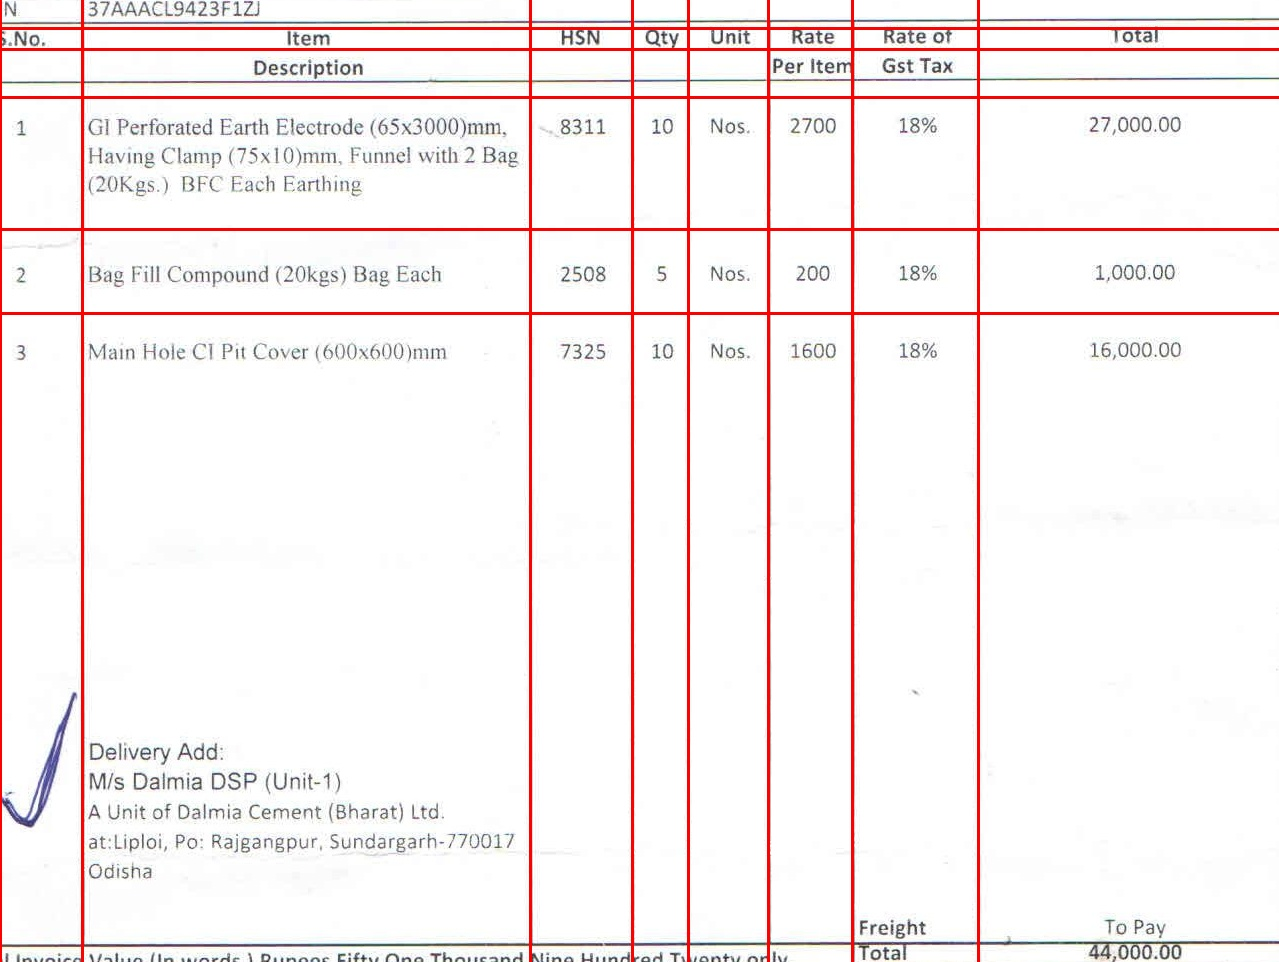

##### 4.3.2  converting merged_rows(final rows and cols nd-array) to dataframe.

In [23]:
rows_df = pd.DataFrame(data=merged_rows[1:], columns=merged_rows[0])
rows_df

,NE >No.,(S7AAACLE42Z3F 12) Item,HSN,Qty,| Unit,Rate,Rate of,Total
0,1,Description Ci Perforated Earth Electrode (65...,8311,10,| Nos,Per 2700,item| Gst Tax 18%,"27,000.00"
1,2,Having Clamp 75s 01mm Vunnel with 2 Bag (2OKa...,2508,5,Nos,200,18%,"1,000.00"
2,3,Main Hote Cl Pit Cover fof. odonam,7325,10,Nos,1600,18%,"16,000.00"


* you can try this API :  <a href="tesseract-sp.herokuapp.com">tesseract-sp.herokuapp.com</a>  to convert cropped_table_image_to_list_of_rows_and_columns..

* The table data extraction can be improved with much more generalized solutions. I will try to improve it in future, and will try to productionize the Automatic Invoice table extraction process.

##### HTML code snippet that helps to print dataframes with borders.

In [24]:
%%HTML
<style type="text/css">
    table.dataframe td, table.dataframe th {
        border-style: solid;
    }
</style>